In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import jax.numpy as jnp
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
#jax.config.update("jax_platform_name", "cpu")
jax.devices()
import matplotlib.pyplot as plt


In [2]:
import frozen_lake
import utils
import plotting
import policies

In [3]:
rng_key = jax.random.PRNGKey(42)
map_size = 8

# initialize env
env = frozen_lake.FrozenLake((map_size,map_size))
rng_key, rng_env_init = jax.random.split(rng_key)
env_params = env.init(rng_env_init)

# create example obs to initialize policy
rng_key, rng_reset, rng_obs = jax.random.split(rng_key, 3)
env_state = env.reset(env_params, rng_reset)
env_obs = env.get_obs(env_params, rng_obs, env_state)

# initialize qnet
qnet = policies.ConvNet([16, 16], 4)
rng_key, rng_policy_init = jax.random.split(rng_key)
net_params = qnet.init(rng_policy_init, env_obs)
policy_params = policies.PolicyParams(net_params)

optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(net_params)

In [4]:
get_action_fn = partial(
    policies.epsilon_greedy,
    get_qval_fn=lambda policy_params, obs: qnet.apply(policy_params.net_params, obs),
)

rollout = jax.jit(
    partial(
        utils.rollout,
        n_steps=1000,
        get_obs_fn=env.get_obs,
        get_action_fn=get_action_fn,
        env_reset_fn=env.reset,
        env_step_fn=env.step,
    )
)

In [5]:
discount = 0.99


@jax.jit
def DDQLearnig(
    optimizer_state: optax.OptState,
    net_params: policies.NetParams,
    terget_net_params: policies.NetParams,
    transitions,
):
    # loss
    def loss_fn(net_params, transitions):
        get_qval_batched = jax.vmap(qnet.apply, in_axes=(None, 0))
        qselected = jnp.take_along_axis(
            get_qval_batched(net_params, transitions.obs),
            transitions.action[:, None],
            axis=-1,
        ).squeeze(-1)
        qnext = jnp.where(
            transitions.done,
            0.0,
            get_qval_batched(net_params, transitions.next_obs).max(axis=-1),
        )
        td = qselected - (transitions.reward + discount * jax.lax.stop_gradient(qnext))
        return jnp.mean(td**2)


    # train
    loss, gradients = jax.value_and_grad(loss_fn)(net_params, transitions)
    updates, optimizer_state = optimizer.update(gradients, optimizer_state)
    net_params = optax.apply_updates(net_params, updates)
    return optimizer_state, net_params, loss

In [6]:
# replace epsilon with 1
policy_params = policy_params.replace(epsilon=1.0)

rng_key, rng_loop = jax.random.split(rng_key)
for rng_rollout in tqdm(jax.random.split(rng_loop, 1000)):
    # rollout
    transitions = rollout(env_params, policy_params, rng_rollout)
    # train qnet
    optimizer_state, net_params, loss = train_step(optimizer_state, net_params, transitions)
    policy_params = policy_params.replace(net_params=net_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%


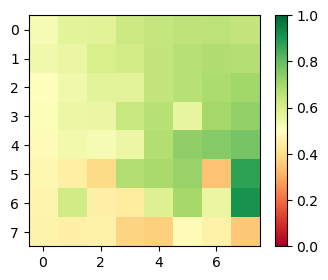

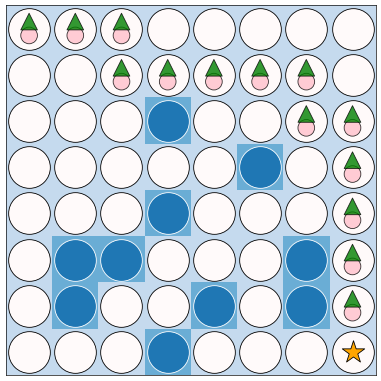

In [8]:
# replace epsilon with 0
policy_params = policy_params.replace(epsilon=0.0)
transitions = rollout(env_params, policy_params, rng_rollout)

plotting.plot_qvals(env, env_params, policy_params.net_params, qnet.apply)
plotting.render(transitions.env_state, env_params)
print(f"{int(100*transitions.reward.sum()/transitions.done.sum())}%")